# App Data Analysis Tutorial

Clark Abbott and Henry Covington

## Introduction

In [2]:
# This is the Final Project Tutorial File
# We will scrape data from https://www.kaggle.com/lava18/google-play-store-apps
# This project is hosted at https://github.com/clabbott/app-data-analysis

#### There's An App For That

As you may know, in 2007 Apple took the world of technology by storm unveiling their newest product, the IPhone. Today, <a href="https://www.pewresearch.org/internet/fact-sheet/mobile/"> 81% of Americans own a smartphone</a> and <a href="https://review42.com/smartphone-statistics/#:~:text=There%20are%205.11%20billion%20unique,billion%20of%20them%20use%20smartphones.&text=100%20million%20people%20have%20started,smartphone%20users%20worldwide%20in%202020.">there are 2.71 billion smartphone users across the globe</a>. 

In IPhone's 3rd generation, Apple's main slogan for the device was "There's An App For That". This slogan called to attention the abundance and resourcefulness of apps. It became such a popular buzz phrase that <a href="https://www.cnn.com/2010/TECH/mobile/10/12/app.for.that/index.html"> Apple trademarked it </a> and gave insperation to <a href="https://youtu.be/EhkxDIr0y2U"> plenty of parodies</a>. But the point stands, <a href="https://www.statista.com/statistics/276623/number-of-apps-available-in-leading-app-stores/#:~:text=What%20are%20the%20biggest%20app,million%20available%20apps%20for%20iOS."> there are over 2.8 billion apps on the Google Play Store and 1.9 on the Apple App Store</a>.

In a world where the amount of apps are overabundant and smartphones become increasingly more integral to communication and entertainment, knowing what qualities get apps installed is valuable information.

#### Importance With Repect to Data Science?
Data Science has a deeper relationship with apps than being important to modern technology. Phone app stores rely heavily on algorithms to rank and query apps to provide a helpful user experience. With billions of apps to sort through, Data Science knowledge is important to the discovery of apps.

#### Tools for the Job
For this tutorial we will use <a href="https://www.python.org/"> Python </a> and several of it's useful libraries to do some of the heavy lifting. Some experience with Python is expected.

<a href="https://pandas.pydata.org/">Pandas</a>: Creates lightweight and easy to manipulate dataframes which we will use to hold our data.

<a href="https://numpy.org/">Numpy</a>: Lots of helpful mathmatic functions.

<a href="">Matplotlib</a>: Data visualization

In [14]:
#import libraries
import pandas as pd
import datetime
import numpy as np
pd.options.mode.chained_assignment = None  # default='warn'
import datetime
import matplotlib.pyplot as plt

## Data Collection

The first step in the data life cycle is to collect data we want to use. Sometimes this means looking around, taking HTML code directly and sorting it into tables. However, there are a lot of public datasets out there and someone might already be providing the data your looking for. <a href="https://www.kaggle.com/">Kaggle</a> is one place where you can find datasets and happens to have the data we are looking for in this tutorial. For this tutorial we are using Lavanya Gupta's 10k Google Play Store database. There is a lot more apps on the market today, but this is a nice sample for our tutorial. You can download and learn more about it <a href="https://www.kaggle.com/lava18/google-play-store-apps">here</a>.

In [10]:
#Read Google Play Store data into dataframe
df = pd.read_csv(r"googleplaystore.csv") 
#Set base data types. We will change some of these as we go on.
df.astype({'App':'str', 'Category':'str', 'Rating':'float32', 
           'Reviews':'str','Size':'str','Installs':'str',
          'Type':'str', 'Price':'str', 'Content Rating':'str', 
           'Genres':'str', 'Last Updated':'str', 'Current Ver':'str',
          'Android Ver':'str'})
df.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


## Data Processing

The table we are scraping from has 13 columns which need to be processed differently and can be reduced and cleaned to a more manageable format. 

The App column is the name of the app and must be interpreted as a String. The names should all be unique. We will be dropping duplicate app names and keeping the apps that have more reviews.

The Category column is the general category of the app and must be interpreted as a String. Many of the apps will have the same category value. 

The Rating column is the average user rating for the app between 1 and 5, with some outliers that must be dropped due to bad data that doesn't fit within these bounds. This value is a float. 

The Reviews column is the number of user reviews for the app. This value is an integer.

The Size column is the size of the app, how much space it takes up on a device. This value contains units of Megabite and other sizes and we have standardized these values to an integer value so they can be understood in context of each other. We drop the value 'Varies with size' due to its ambigiuity. 

The Installs column is the number of devices that have installed the app. The raw data gives units in minimum possible values so we interpreted these minimum values into integer values. 

The Type column is whether it is a free app or not. This is a string value that we will interpret as a boolean value with True for Free and False for Not Free.

The Price column is the price of the app. Once we remove the dollar sign from the price of some of these values, this is interpreted as a float value. 

The Content Rating column is a string determining which group the app is developed for. We had to break these columns down into fewer categories with only a few unique values to be able to analyze the data. The categories we chose were "Everyone", "Teen", and "Adult".

The Genres Column is a succinct, general category for the app's content. Most apps fit into one of the multiple major categories but there are also a number of apps with more specific categories. For these apps, we placed them in one of the major categories by scanning for keywords that would give clues to their categorical placement. We formatted this column as strings. 

The Last Updated Column contains date information for when the app was last updated. We cleaned this data by parsing it using the datetime library so it was easier to sort through.

The Current Ver Column is a string detailing the current version of the app available on the Play Store at the time of scraping. 

The Android Ver Column is a string detailing the minimum required version of the app to work on an android device.

Notably, the scraper of the dataset included that the row for "Life Made WI-Fi Touchscreen Photo Frame" was formatted incorrectly so we made the choice to drop that entry, other incorrectly formatted entries, and entries with NaN in a column before cleaning. 

In [11]:
#Dropping Life Made WI-Fi Touchscreen Photo Frame and Command & Conquer: Rivals which are malformed
df = df.drop([10472, 9148])

# Dropping rows that contain any NaN
df.dropna()

# Dropping Current Ver and Android Ver due to their unuse 
df.drop(columns=['Current Ver', 'Android Ver'])

#Formatting App 

#Dropping Duplicates, Keep app with most reviews
df = df.sort_values('Reviews', ascending=False)
df = df.drop_duplicates(subset='App', keep='first') #1181 Dropped Apps
df = df.sort_index() #Sort back by index

#Formatting Reviews

#Converting to Numeric
df['Reviews'] = pd.to_numeric(df['Reviews'])


#Formatting Size

#Converting "Varies with device" with NaN values
#Life Made WI-Fi Touchscreen Photo Frame with a size of 1000+ is also replaced with a NaN value
#This makes the column useable, but biased with against these values.
df['Size'] = df['Size'].replace("Varies with device", np.NaN)

#Converts Size from string to a kb value
#Values that end in Mb are converted to kb
def data_string_to_int(data_str):
    return {
        'k':float(data_str[:-1]),
        'M':float(data_str[:-1]) * 1000
    }.get(data_str[-1:], np.NaN)


df['Size'] = df['Size'].apply(lambda x:  data_string_to_int(x) if pd.notnull(x) else x)
df['Size'] = pd.to_numeric(df['Size'])


# Formatting Installs
# Drops plusses and commas from the strings in the Installs column

for index, row in df.iterrows():
    df['Installs'][index] = df['Installs'][index][:-1]
    df['Installs'][index] = df['Installs'][index].replace(',','')

df = df.astype({'Installs': 'int32'})


# Formatting Type
# Change name of column from "Type" to "Is_Free" and transform it into a boolean value
df = df.rename(columns={"Type": "Is_Free"})
df['Is_Free'] = df['Is_Free'] == 'Free'


# Formatting Price
# Remove dollar sign from front (if necessary) and change to float
for index, row in df.iterrows():
    if "$" in df['Price'][index]:
        df['Price'][index] = df['Price'][index][1:]
df = df.astype({'Price': 'float32'})


# Formatting Content Rating

# This function performs the "in" function over a list of possible values that might be in the string. 
def any_elt_in_list_in_string(list_p, string_p):
    for elt in list_p:
        if(elt in string_p):
            return True
    return False

# Created three new columns tied to the "Everyone", "Teen", and "Adult" content ratings. 
for index, row in df.iterrows():
    if (any_elt_in_list_in_string(["Mature", "Adults","Unrated"], df['Content Rating'][index])):
        df['Content Rating'][index] = "Adult"
    elif ("Teen" in df['Content Rating'][index]):
        df['Content Rating'][index] = "Teen"
    elif ("Everyone" in df['Content Rating'][index]):
        df['Content Rating'][index] = "Everyone"
    else:
        df['Content Rating'][index] = "NaN"
        pass
    pass


# These are nominal values so they require being encoded as dummy variables first. https://www.dataquest.io/blog/machine-learning-preparing-data/
# Separated them in order to allow for machine learning and data analysis

dummy_df = pd.get_dummies(df[["Content Rating"]])
df = pd.concat([df, dummy_df], axis=1)
df = df.drop(["Content Rating"], axis=1)


# Formatting Genres
# Create eight different genres organized by keywords that pertain to that genre. 

# Utilities have a single or small range of tasks and manage the phone's UI and most basic functionalities. 
# Basic functionalities includes basic Internet browsing, cellular communication, health tracking, and gps
utilities_keywords = ["Tools", "Personalization", "Maps", "Medical"]
# Social Networking apps are apps whose primary functions are to enable abstracted communication with people over the internet. 
social_networking_keywords = ["Communication","Social", "Dating"]
# Lifestyle apps are apps that are designed for continual use that have a more complicated function than utilites. 
# These apps have a primary purpose which is not back-and-forth communication with people on the internet. 
lifestyle_keywords = ["Beauty", "Events", "Finance", "Food & Drink", "Health & Fitness", "House & Home", "Lifestyle", 
                      "Shopping", "Travel", "Weather", "News"]
# Productivity apps have all the features of lifestyle apps but are focused on helping people accomplish tasks quicker/easier.
# Books are in this category because you dont have to go and buy a physical book, you can get one and read it right away on 
# your device. 
productivity_keywords = ["Business", "Productivity", "Auto & Vehicles"]
# Education apps are productivity apps that are specifically focused on educational productivity
education_keywords = ["Education", "Educational", "Libraries & Demo", "Books & Reference", "Parenting", "Pretend Play"]
# Entertainment apps are apps that are focused on helping a user have fun. These are separated from games as a category 
# due to the sheer number of games on the app store. 
entertainment_keywords = ["Comics", "Entertainment", "Music", "Video Player", "Brain Games", "Music & Video"]
# Creativity apps are apps that allow users to be creative as a primary function, usually with the hardware of the device.
creativity_keywords = ["Art & Design","Photo","Creativity", "Video Players & Editors"]
# Games are apps that are defined by their high degree of interactivity and entertainment.
games_keywords = ["Arcade", "Puzzle", "Racing", "Sports", "Casual","Adventure","Card", "Simulation",
                  "Trivia", "Action", "Word", "Role Playing", "Strategy","Game", "Board","Casino",
                 "Pretend Play"]

# Now we seperate the genres
# An app with a semicolon has two genre keywords: if the genre keywords denote two different genres, the app will be entered 
# into the table again to denote its membership to two different categories. This enables the genre data to be analyzed 
# within one variable without having to split it among two different variables, but looking at the dataset as a whole must 
# be filtered for duplicate entries again to avoid double-counting apps that cross genres. 

# index is from the current row in the table, df is the df
# prev_genre is "" if this is the first time the function is run and a value if it is the second time this function is run
def find_genre_by_keyword(index, df, prev_genre):
    ret_genre = None
    if (any_elt_in_list_in_string(utilities_keywords, df['Genres'][index])):
        if(prev_genre != "Utilities"):
            ret_genre = "Utilities"
    if (any_elt_in_list_in_string(social_networking_keywords, df['Genres'][index])):
        if(prev_genre != "Social Networking"):
            ret_genre = "Social Networking"
    if (any_elt_in_list_in_string(lifestyle_keywords, df['Genres'][index])):
        if(prev_genre != "Lifestyle"):
            ret_genre = "Lifestyle"
    if (any_elt_in_list_in_string(productivity_keywords, df['Genres'][index])):
        if(prev_genre != "Productivity"):
            ret_genre = "Productivity"
    if (any_elt_in_list_in_string(education_keywords, df['Genres'][index])):
        if(prev_genre != "Education"):
            ret_genre = "Education"
    if (any_elt_in_list_in_string(entertainment_keywords, df['Genres'][index])):
        if(prev_genre != "Entertainment"):
            ret_genre = "Entertainment" 
    if (any_elt_in_list_in_string(creativity_keywords, df['Genres'][index])):
        if(prev_genre != "Creativity"):
            ret_genre = "Creativity" 
    if (any_elt_in_list_in_string(games_keywords, df['Genres'][index])):
        if(prev_genre != "Games"):
            ret_genre = "Games"
    return ret_genre
       

# This for loop iterates through the rows of the df
for index, row in df.iterrows():
    genre_1 = find_genre_by_keyword(index, df, "")
     # Checks for semicolons to create another genre if necessary
    if(';' in df['Genres'][index]):
        genre_2 = find_genre_by_keyword(index, df, genre_1)
    else:
        genre_2 = None
    if not(genre_2 is None):
        # Make deep copy of the row
        new_entry = row.copy()
        # change the genre column of new_entry to be genre_2's value
        new_entry['Genres'] = genre_2
        # make a new entry in df for this deep copy
        df = df.append(new_entry)
    # change the genre column to be genre_1's value 
    df['Genres'][index] = genre_1

# Rename "Genres" to "Genre" to prepare for shift
df = df.rename(columns={"Genres": "Genre"})
    
# genres are now successfully categorized in 8 groups. Now we enter the values of Genre as dummy values then drop the Genre column
dummy_df = pd.get_dummies(df[["Genre"]])
df = pd.concat([df, dummy_df], axis=1)
df = df.drop(["Genre"], axis=1)
df

#Now we want to combine the duplicates together.
df = df.groupby(['App'], as_index=False).agg({'App': 'first', 'Category': 'first', 'Rating': 'first', 'Reviews': 'first', 'Size': 'first', 'Installs': 'first', 
                              'Is_Free': 'first', 'Price': 'first', 'Size': 'first', 'Content Rating_Adult': 'first',
                              'Content Rating_Everyone': 'first', 'Content Rating_Teen': 'first', 'Last Updated': 'first', 
                                              'Genre_Creativity': 'sum', 'Genre_Education': 'sum', 'Genre_Entertainment': 'sum', 'Genre_Games': 'sum'
                             , 'Genre_Lifestyle': 'sum', 'Genre_Productivity': 'sum', 'Genre_Social Networking': 'sum', 'Genre_Utilities': 'sum'
                             , })
df = df.sort_values(by = ['Installs'], ascending=False)

# Formatting Last Updated
df['Last Updated']= pd.to_datetime(df['Last Updated'])
df.dtypes

App                                object
Category                           object
Rating                            float64
Reviews                             int64
Size                              float64
Installs                            int64
Is_Free                              bool
Price                             float64
Content Rating_Adult                int64
Content Rating_Everyone             int64
Content Rating_Teen                 int64
Last Updated               datetime64[ns]
Genre_Creativity                    uint8
Genre_Education                     uint8
Genre_Entertainment                 uint8
Genre_Games                         uint8
Genre_Lifestyle                     uint8
Genre_Productivity                  uint8
Genre_Social Networking             uint8
Genre_Utilities                     uint8
dtype: object

## Exploratory Analysis and Visualization 

Now that our data is cleaned up the next step in the data science life cycle is Exploratory Analysis and Visualization. This is where we plot data and analyse it at surface level to seek potential trends.

### Temporary Analysis?

Hey Clark, so everything here isn't intended to be in the final product of our project, but could be repurposed/restructured. So originally we agreed (honestly due to my insistence) to use Installs as our main predictive variable. It didn't take much graphing to notice that there are a few problems. Installs may look like a numerical variable, but it behaves much more like a categorical variable.

In [31]:
#amount of unique values in Installs
print(df["Installs"].unique())

[1000000000  500000000  100000000   50000000   10000000    5000000
    1000000     500000     100000      50000      10000       5000
       1000        500        100         50         10          5
          1          0]


So installs moves up a decimal every two increments after switching from 1 to 5. So in addition to it being awkward to predict, it also grows exponentally which makes graphs awkward.  

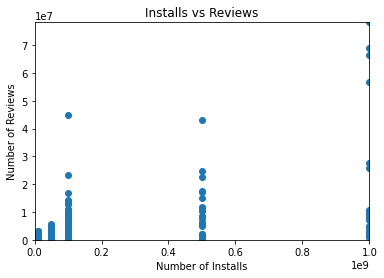

In [66]:
plt.xlabel("Number of Installs")
plt.ylabel("Number of Reviews")
plt.title("Installs vs Reviews")
plt.scatter(df["Installs"],df["Reviews"])
plt.xlim(df["Installs"].min(), df["Installs"].max())
plt.ylim(df["Reviews"].min(), df["Reviews"].max())
plt.autoscale(False)
#If we use this graph in the final product scales need to be adjusted.

Luckally reviews is a different story. We seem to get exact numbers with reviews. However as seen from the graph above, reviews don't necessarily installs which might make the variable unreliable in determining success. Also reviews have lots of zero values

In [51]:
print(df["Reviews"].unique())
print("Number of unique vars in reviews: ",len(df["Reviews"].unique()))

[ 1433233 69119316 25655305 ...        5      200      594]
Number of unique vars in reviews:  5330
592


Also worth noting that both graphs distribuitions are awful. Zero values from garbage apps people toss out onto the store plummet our average.

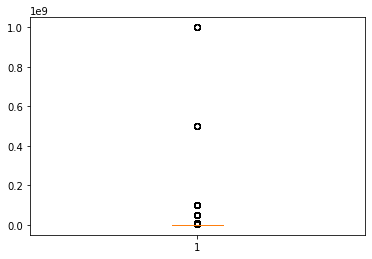

In [98]:
plt.boxplot(df["Installs"]);

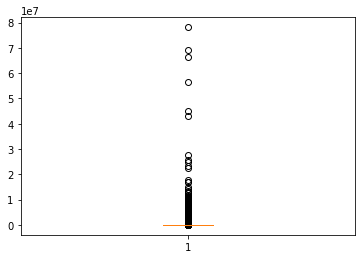

In [62]:
plt.boxplot(df["Reviews"]);

So we have a few options.

- We could try and carry on with installs as a numerical value. (Prob unwise)
- We could treat installs as a categorical value and use prediction methods like random trees.
- We could use number of reviews instead of installs

Below are some graphs to explore this more

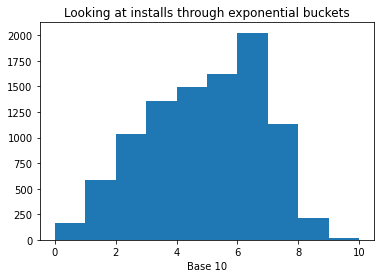

In [100]:
plt.xlabel("Base 10")
plt.title("Looking at installs through exponential buckets")
plt.hist(df["Installs"].apply(lambda x: math.log10(x + 1)), bins=[0,1,2,3,4,5,6,7,8,9,10]);

In [4]:
# Later in project: Save half of the data for training and the other half for testing when making a predictive model
# I predict there are small issues with the genre system but I will work them out later, things should work without breaking rn